In [1]:
# --- STEP 1 (Colab): Upload and load Excel files (Asymmetry only) ---
from google.colab import files
import pandas as pd
import io
import re

print("📂 Please upload these 2 files together:")
print("  • 271_training_cohort_4_new_PRS_cleaned.xlsx")
print("  • 1013_testing_cohort_pure_suspects.xlsx\n")

uploaded = files.upload()

# --- Identify files by name pattern ---
train_key = next((k for k in uploaded if re.search(r"271.*training", k, re.I)), None)
suspect_key = next((k for k in uploaded if re.search(r"1013.*(testing|suspect)", k, re.I)), None)

assert train_key is not None, "❌ Could not find the 271 training Excel file in uploads."
assert suspect_key is not None, "❌ Could not find the 1013 suspect Excel file in uploads."

# --- Load Excel files ---
train_df = pd.read_excel(io.BytesIO(uploaded[train_key]))
suspect_df = pd.read_excel(io.BytesIO(uploaded[suspect_key]))

print("✅ Files loaded successfully:")
print(f"  Training cohort: {train_key}  shape={train_df.shape}")
print(f"  Suspect cohort: {suspect_key}  shape={suspect_df.shape}")

# --- Define required asymmetry columns ---
ASYM_COLS = ["delta_IOP", "delta_CDR", "delta_RNFL"]

print("\n🔎 Column check:")
print("  Asymmetry cols present in training:", {c: (c in train_df.columns) for c in ASYM_COLS})
print("  Asymmetry cols present in suspects:", {c: (c in suspect_df.columns) for c in ASYM_COLS})

# --- Missingness summary ---
missing_train = train_df[ASYM_COLS].isna().sum()
missing_suspect = suspect_df[ASYM_COLS].isna().sum()

print("\n🧪 Missing values (Training cohort):")
print(missing_train.to_string())

print("\n🧪 Missing values (Suspect cohort):")
print(missing_suspect.to_string())

# --- Try to auto-detect label column in training set ---
possible_label_cols = ["label", "Label", "CASE_CONTROL", "case_control", "status", "Status", "POAG", "poag"]
label_col = next((c for c in possible_label_cols if c in train_df.columns), None)
print("\n🏷️ Detected label column in training:", label_col)


📂 Please upload these 2 files together:
  • 271_training_cohort_4_new_PRS_cleaned.xlsx
  • 1013_testing_cohort_pure_suspects.xlsx



Saving 271_training_cohort_4_new_PRS_cleaned.xlsx to 271_training_cohort_4_new_PRS_cleaned (1).xlsx
Saving 1013_testing_cohort_pure_suspects.xlsx to 1013_testing_cohort_pure_suspects (1).xlsx
✅ Files loaded successfully:
  Training cohort: 271_training_cohort_4_new_PRS_cleaned (1).xlsx  shape=(271, 48)
  Suspect cohort: 1013_testing_cohort_pure_suspects (1).xlsx  shape=(1013, 49)

🔎 Column check:
  Asymmetry cols present in training: {'delta_IOP': True, 'delta_CDR': True, 'delta_RNFL': True}
  Asymmetry cols present in suspects: {'delta_IOP': True, 'delta_CDR': True, 'delta_RNFL': True}

🧪 Missing values (Training cohort):
delta_IOP      4
delta_CDR     14
delta_RNFL    53

🧪 Missing values (Suspect cohort):
delta_IOP       0
delta_CDR      62
delta_RNFL    534

🏷️ Detected label column in training: None


In [2]:
# --- STEP 2: Build Asymmetry feature sets (+ PRS) and define label ---

import pandas as pd
import numpy as np

# Copy training data
df_train = train_df.copy()

# --- Define label column ---
LABEL_COL = "CaseCtrl"
assert LABEL_COL in df_train.columns, f"❌ Label column '{LABEL_COL}' not found in training dataframe."

# Keep only rows with valid labels (do NOT drop NA in features here)
df_train = df_train.dropna(subset=[LABEL_COL]).copy()
df_train[LABEL_COL] = df_train[LABEL_COL].astype(int)

# y label (0=control, 1=case)  [assuming your encoding follows this; we can confirm later]
y = df_train[LABEL_COL].values

print("✅ Training label ready:")
print("  y counts:", dict(pd.Series(y).value_counts().sort_index()))

# --- Define feature columns ---
ASYM_COLS = ["delta_IOP", "delta_CDR", "delta_RNFL"]
PRS_COLS  = ["POAAGG PRS", "MEGA PRS", "PRS526", "PRS616"]

# Sanity check
missing_cols = [c for c in ASYM_COLS + PRS_COLS if c not in df_train.columns]
assert len(missing_cols) == 0, f"❌ Missing required columns in training dataframe: {missing_cols}"

# --- Build feature sets ---
feature_sets = {}

# (A) delta only
for d in ASYM_COLS:
    feature_sets[d] = [d]

# (B) delta + each PRS
for d in ASYM_COLS:
    for prs in PRS_COLS:
        feature_sets[f"{d}+{prs}"] = [d, prs]

# (C) delta + all PRS (optional, but useful as a benchmark)
for d in ASYM_COLS:
    feature_sets[f"{d}+ALL_PRS"] = [d] + PRS_COLS

print("\n✅ Feature sets created:", len(feature_sets))
print("Example keys:", list(feature_sets.keys())[:8])

# --- Quick missingness report for these columns in training ---
cols_to_check = sorted(set(ASYM_COLS + PRS_COLS))
miss = df_train[cols_to_check].isna().sum().to_frame("n_missing")
miss["pct_missing"] = (miss["n_missing"] / len(df_train) * 100).round(2)

print("\n🧪 Missingness summary (training, for selected columns):")
display(miss)


✅ Training label ready:
  y counts: {0: np.int64(143), 1: np.int64(128)}

✅ Feature sets created: 18
Example keys: ['delta_IOP', 'delta_CDR', 'delta_RNFL', 'delta_IOP+POAAGG PRS', 'delta_IOP+MEGA PRS', 'delta_IOP+PRS526', 'delta_IOP+PRS616', 'delta_CDR+POAAGG PRS']

🧪 Missingness summary (training, for selected columns):


,n_missing,pct_missing
MEGA PRS,0,0.00
POAAGG PRS,0,0.00
PRS526,0,0.00
PRS616,0,0.00
delta_CDR,14,5.17
delta_IOP,4,1.48
delta_RNFL,53,19.56


In [3]:
# --- STEP 3: Train (SVM, RF, MLP) on asymmetry feature sets with bootstrap metrics (Mean ± SEM) ---

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import resample

RANDOM_STATE = 42
n_bootstraps = 50   # 建议至少 50；你之前用 10 太少，SEM 不稳定

# --- Define models (keep them modest for small N) ---
models = {
    "RF": RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight="balanced_subsample",
        bootstrap=True,
        random_state=RANDOM_STATE
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-3,
        learning_rate_init=1e-3,
        batch_size=32,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=50,
        validation_fraction=0.2,
        random_state=RANDOM_STATE
    ),
    "SVM": SVC(
        kernel="rbf",
        C=4.0,
        gamma=2.0,
        class_weight="balanced",
        probability=True,
        random_state=RANDOM_STATE
    ),
}

# --- Helper: compute metrics safely ---
def compute_metrics(y_true, y_pred, y_prob):
    # Confusion matrix: [[TN, FP],[FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity (Recall for positive class)
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    # Specificity (Recall for negative class)
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # F1 for positive class (robust)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[1], average=None, zero_division=0
    )
    f1_pos = f1[0]

    # AUC (need probabilities)
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) == 2 else np.nan

    return {"Accuracy": acc, "F1": f1_pos, "AUC": auc, "Sensitivity": sens, "Specificity": spec}


# --- Main bootstrap loop ---
results = []

for fs_name, cols in feature_sets.items():
    X_full = df_train[cols].copy()
    y_full = y.copy()

    for model_name, model in models.items():
        metric_store = {k: [] for k in ["Accuracy","F1","AUC","Sensitivity","Specificity"]}

        for b in range(n_bootstraps):
            # Stratified bootstrap resample
            X_res, y_res = resample(
                X_full, y_full,
                replace=True,
                n_samples=len(y_full),
                stratify=y_full,
                random_state=RANDOM_STATE + b
            )

            # Train/test split (stratified)
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_res, y_res,
                test_size=0.2,
                stratify=y_res,
                random_state=RANDOM_STATE + b
            )

            # Pipeline: impute + scale + model
            pipe = Pipeline([
                ("imputer", SimpleImputer(strategy="mean")),
                ("scaler", StandardScaler()),
                ("clf", model),
            ])

            pipe.fit(X_tr, y_tr)
            y_pred = pipe.predict(X_te)
            y_prob = pipe.predict_proba(X_te)[:, 1]

            m = compute_metrics(y_te, y_pred, y_prob)
            for k, v in m.items():
                metric_store[k].append(v)

        # Summarize Mean ± SEM
        for metric_name, vals in metric_store.items():
            vals = np.array(vals, dtype=float)
            mean = np.nanmean(vals)
            sem  = np.nanstd(vals, ddof=1) / np.sqrt(np.sum(~np.isnan(vals)))

            results.append({
                "FeatureSet": fs_name,
                "Model": model_name,
                "Metric": metric_name,
                "Mean": mean,
                "SEM": sem,
                "Mean±SEM": f"{mean:.3f} ± {sem:.3f}"
            })

results_df = pd.DataFrame(results)

print("✅ Done. Results shape:", results_df.shape)
display(results_df.head(15))

# --- Save long format + wide AUC table (useful for plotting later) ---
results_df.to_excel("asymmetry_bootstrap_metrics_long.xlsx", index=False)

auc_wide = (results_df[results_df["Metric"]=="AUC"]
            .pivot_table(index="FeatureSet", columns="Model", values="Mean"))
auc_wide.to_excel("asymmetry_AUC_wide.xlsx")

from google.colab import files
files.download("asymmetry_bootstrap_metrics_long.xlsx")
files.download("asymmetry_AUC_wide.xlsx")


✅ Done. Results shape: (270, 6)


,FeatureSet,Model,Metric,Mean,SEM,Mean±SEM
0,delta_IOP,RF,Accuracy,0.741091,0.007802,0.741 ± 0.008
1,delta_IOP,RF,F1,0.699056,0.010227,0.699 ± 0.010
2,delta_IOP,RF,AUC,0.822599,0.007407,0.823 ± 0.007
3,delta_IOP,RF,Sensitivity,0.648462,0.017855,0.648 ± 0.018
4,delta_IOP,RF,Specificity,0.824138,0.018280,0.824 ± 0.018
5,delta_IOP,MLP,Accuracy,0.744727,0.006340,0.745 ± 0.006
6,delta_IOP,MLP,F1,0.688032,0.010962,0.688 ± 0.011
7,delta_IOP,MLP,AUC,0.810106,0.007821,0.810 ± 0.008
8,delta_IOP,MLP,Sensitivity,0.613077,0.017285,0.613 ± 0.017
9,delta_IOP,MLP,Specificity,0.862759,0.011594,0.863 ± 0.012


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# --- STEP 4 (Clean): Train RF on (delta_IOP, delta_CDR, delta_RNFL, PRS616) and predict risk in 1013 suspects ---

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from google.colab import files

RANDOM_STATE = 42

# =======================
# 1) Define feature set (keep all 3 asymmetry + PRS616)
# =======================
FEATURE_COLS = ["delta_IOP", "delta_CDR", "delta_RNFL", "PRS616"]
LABEL_COL = "CaseCtrl"

# Sanity checks
for c in FEATURE_COLS:
    assert c in df_train.columns, f"❌ Missing column in training: {c}"
    assert c in suspect_df.columns, f"❌ Missing column in suspects: {c}"
assert LABEL_COL in df_train.columns, f"❌ Missing label column in training: {LABEL_COL}"

print("✅ Using features:", FEATURE_COLS)

# =======================
# 2) Prepare train data
# =======================
X_train = df_train[FEATURE_COLS].copy()
y_train = df_train[LABEL_COL].astype(int).values

print("Training cohort size:", len(df_train))
print("Label distribution:", dict(pd.Series(y_train).value_counts().sort_index()))

# =======================
# 3) Define ONE classifier: Random Forest
# =======================
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced_subsample",
    bootstrap=True,
    random_state=RANDOM_STATE
)

# =======================
# 4) Fit final pipeline on full training cohort
# =======================
final_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", rf),
])

final_pipe.fit(X_train, y_train)
print("✅ RF model fitted on full training cohort.")

# =======================
# 5) Predict risk in suspect cohort
# =======================
X_sus = suspect_df[FEATURE_COLS].copy()
suspect_pred_risk = final_pipe.predict_proba(X_sus)[:, 1]

suspect_out = suspect_df.copy()
suspect_out["predicted_risk"] = suspect_pred_risk

# Bin to 0.05 (like Figure 5)
suspect_out["risk_bin_0.05"] = np.floor(suspect_out["predicted_risk"] / 0.05) * 0.05
suspect_out["risk_bin_0.05"] = suspect_out["risk_bin_0.05"].clip(0, 0.95)

print("\nPredicted risk summary:")
display(suspect_out["predicted_risk"].describe())

# =======================
# 6) Save + download
# =======================
out_name = "suspect_predicted_risk_RF_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx"
suspect_out.to_excel(out_name, index=False)

files.download(out_name)
print("📦 Downloaded:", out_name)


✅ Using features: ['delta_IOP', 'delta_CDR', 'delta_RNFL', 'PRS616']
Training cohort size: 271
Label distribution: {0: np.int64(143), 1: np.int64(128)}
✅ RF model fitted on full training cohort.

Predicted risk summary:


,predicted_risk
count,1013.000000
mean,0.413830
std,0.210533
min,0.048287
25%,0.287524
50%,0.392367
75%,0.575676
max,0.980551


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: suspect_predicted_risk_RF_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx


✅ Using suspect_out from memory.


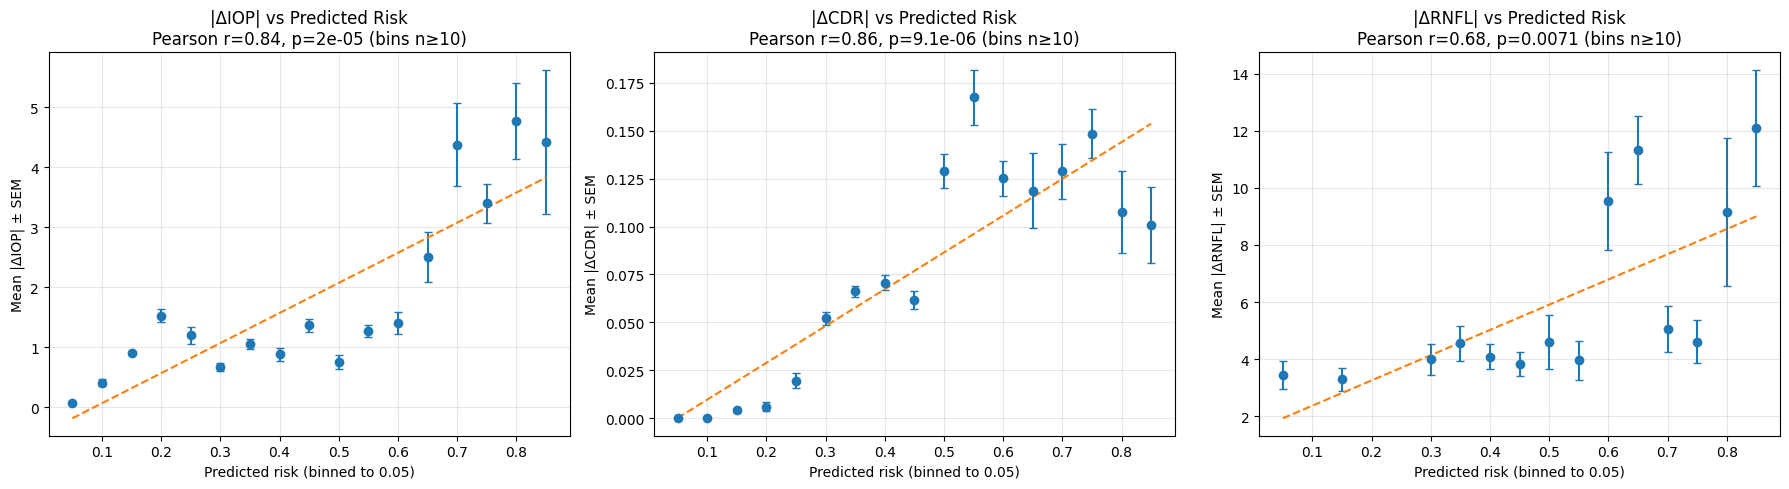

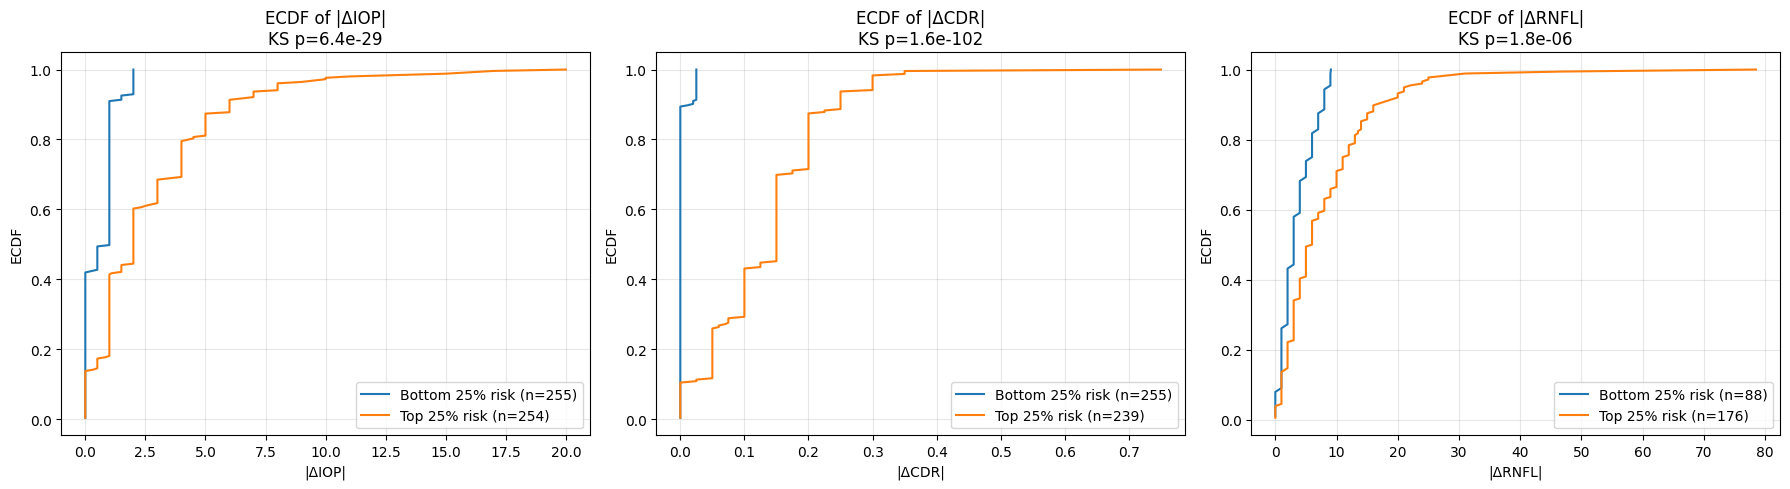

,Phenotype,Pearson_r (bin_mean),Pearson_p,KS_p (top vs bottom 25%),N_low25,N_high25
0,|ΔIOP|,0.844777,0.000020,6.350001e-29,255,254
1,|ΔCDR|,0.861042,0.000009,1.648854e-102,255,239
2,|ΔRNFL|,0.683043,0.007092,1.764229e-06,88,176


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# --- STEP 5: Biological validation in suspects (Figure 5 style, but for asymmetry) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

# 1) Load the suspect output from Cell 4 (or use suspect_out if still in memory)
FILE = "suspect_predicted_risk_RF_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx"

try:
    df_sus = suspect_out.copy()
    print("✅ Using suspect_out from memory.")
except NameError:
    df_sus = pd.read_excel(FILE)
    print(f"✅ Loaded: {FILE}")

# 2) Prepare asymmetry magnitudes (absolute differences)
df_sus["abs_delta_IOP"]  = df_sus["delta_IOP"].abs()
df_sus["abs_delta_CDR"]  = df_sus["delta_CDR"].abs()
df_sus["abs_delta_RNFL"] = df_sus["delta_RNFL"].abs()

PHENOS = ["abs_delta_IOP", "abs_delta_CDR", "abs_delta_RNFL"]
PHENO_LABELS = {
    "abs_delta_IOP":  "|ΔIOP|",
    "abs_delta_CDR":  "|ΔCDR|",
    "abs_delta_RNFL": "|ΔRNFL|"
}

# 3) Binning (already created in Cell 4, but re-make to be safe)
df_sus["risk_bin_0.05"] = np.floor(df_sus["predicted_risk"] / 0.05) * 0.05
df_sus["risk_bin_0.05"] = df_sus["risk_bin_0.05"].clip(0, 0.95)

# Option: filter bins with too few samples to make trend cleaner
MIN_BIN_N = 10

# -------------------------
# Figure 5A-style: risk bins vs mean phenotype ± SEM + Pearson r/p
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    tmp = df_sus[["risk_bin_0.05", pheno]].dropna().copy()

    # group stats by bin
    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({
        "mean": g.mean(),
        "sem":  g.std(ddof=1) / np.sqrt(g.count()),
        "n":    g.count()
    }).reset_index()

    # filter small bins
    stats_f = stats[stats["n"] >= MIN_BIN_N].copy()

    # Pearson correlation using bin centers and mean phenotype
    if len(stats_f) >= 3:
        r, p = pearsonr(stats_f["risk_bin_0.05"].values, stats_f["mean"].values)
    else:
        r, p = np.nan, np.nan

    # plot
    ax.errorbar(
        stats_f["risk_bin_0.05"], stats_f["mean"],
        yerr=stats_f["sem"],
        fmt="o", capsize=3
    )

    # simple linear fit (for visual)
    if len(stats_f) >= 2:
        x = stats_f["risk_bin_0.05"].values
        y = stats_f["mean"].values
        coef = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        yy = coef[0] * xx + coef[1]
        ax.plot(xx, yy, linestyle="--")

    ax.set_title(f"{PHENO_LABELS[pheno]} vs Predicted Risk\nPearson r={r:.2f}, p={p:.2g} (bins n≥{MIN_BIN_N})")
    ax.set_xlabel("Predicted risk (binned to 0.05)")
    ax.set_ylabel(f"Mean {PHENO_LABELS[pheno]} ± SEM")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figure_Asymmetry_Validation_Trend_RF.png", dpi=300)
plt.show()

# -------------------------
# Figure 5B-style: ECDF (Top 25% vs Bottom 25%) + KS test
# -------------------------
# Define top/bottom quartiles by predicted risk
q25 = df_sus["predicted_risk"].quantile(0.25)
q75 = df_sus["predicted_risk"].quantile(0.75)

low = df_sus[df_sus["predicted_risk"] <= q25].copy()
high = df_sus[df_sus["predicted_risk"] >= q75].copy()

def ecdf(arr):
    arr = np.sort(arr)
    y = np.arange(1, len(arr)+1) / len(arr)
    return arr, y

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    a = low[pheno].dropna().values
    b = high[pheno].dropna().values

    # KS test
    if len(a) > 0 and len(b) > 0:
        ks = ks_2samp(a, b)
        p_ks = ks.pvalue
    else:
        p_ks = np.nan

    xa, ya = ecdf(a)
    xb, yb = ecdf(b)

    ax.plot(xa, ya, label=f"Bottom 25% risk (n={len(a)})")
    ax.plot(xb, yb, label=f"Top 25% risk (n={len(b)})")

    ax.set_title(f"ECDF of {PHENO_LABELS[pheno]}\nKS p={p_ks:.2g}")
    ax.set_xlabel(PHENO_LABELS[pheno])
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig("Figure_Asymmetry_Validation_ECDF_RF.png", dpi=300)
plt.show()

# -------------------------
# Save a compact stats table too (useful for manuscript)
# -------------------------
summary_rows = []
for pheno in PHENOS:
    tmp = df_sus[[pheno, "predicted_risk", "risk_bin_0.05"]].dropna()
    # bin stats
    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({"mean": g.mean(), "sem": g.std(ddof=1)/np.sqrt(g.count()), "n": g.count()})
    stats = stats[stats["n"] >= MIN_BIN_N].reset_index()

    if len(stats) >= 3:
        r, p = pearsonr(stats["risk_bin_0.05"].values, stats["mean"].values)
    else:
        r, p = np.nan, np.nan

    # KS
    a = low[pheno].dropna().values
    b = high[pheno].dropna().values
    p_ks = ks_2samp(a, b).pvalue if (len(a) > 0 and len(b) > 0) else np.nan

    summary_rows.append({
        "Phenotype": PHENO_LABELS[pheno],
        "Pearson_r (bin_mean)": r,
        "Pearson_p": p,
        "KS_p (top vs bottom 25%)": p_ks,
        "N_low25": len(a),
        "N_high25": len(b)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)
summary_df.to_excel("Asymmetry_Validation_Stats_RF.xlsx", index=False)

from google.colab import files
files.download("Figure_Asymmetry_Validation_Trend_RF.png")
files.download("Figure_Asymmetry_Validation_ECDF_RF.png")
files.download("Asymmetry_Validation_Stats_RF.xlsx")


MLP

✅ Using df_train from memory.
✅ Using suspect_df from memory.

✅ MLP Feature columns: ['delta_IOP', 'delta_CDR', 'delta_RNFL', 'PRS616']
Training N: 271  Label counts: {0: np.int64(143), 1: np.int64(128)}
✅ MLP model fitted on full training cohort.

Predicted risk summary (MLP):


,predicted_risk
count,1013.000000
mean,0.451446
std,0.252595
min,0.078714
25%,0.225253
50%,0.409979
75%,0.666807
max,0.999296


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: suspect_predicted_risk_MLP_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx


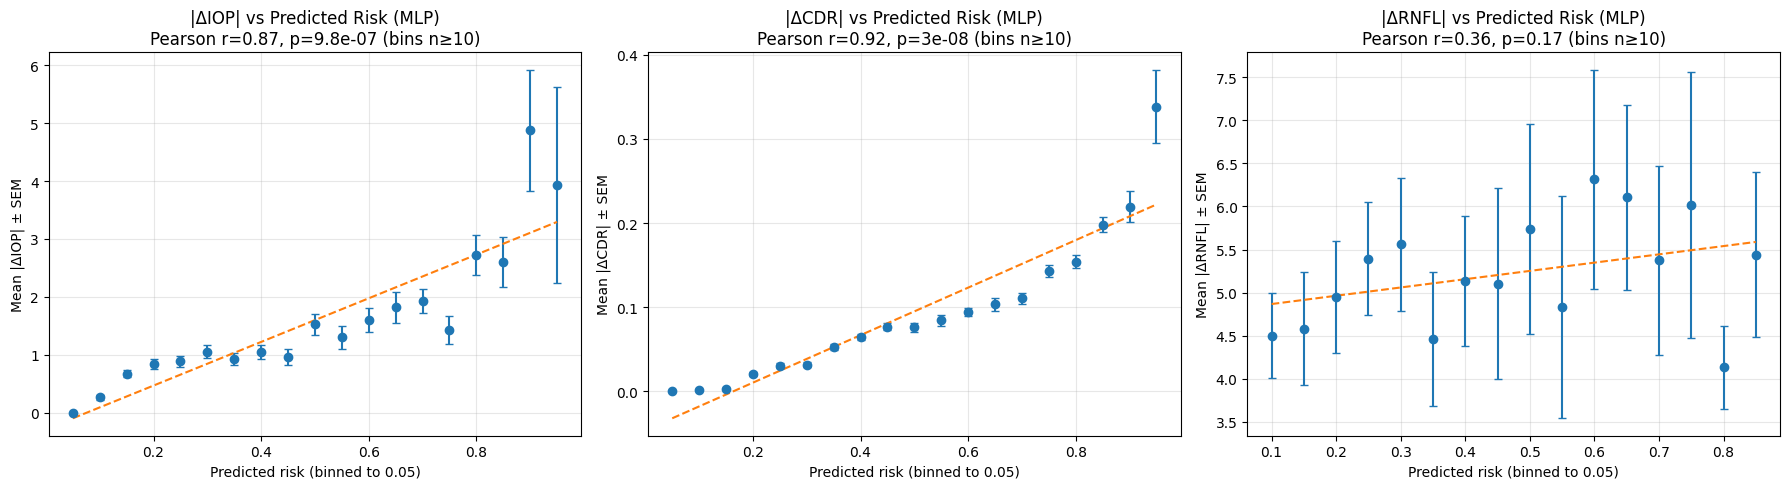

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

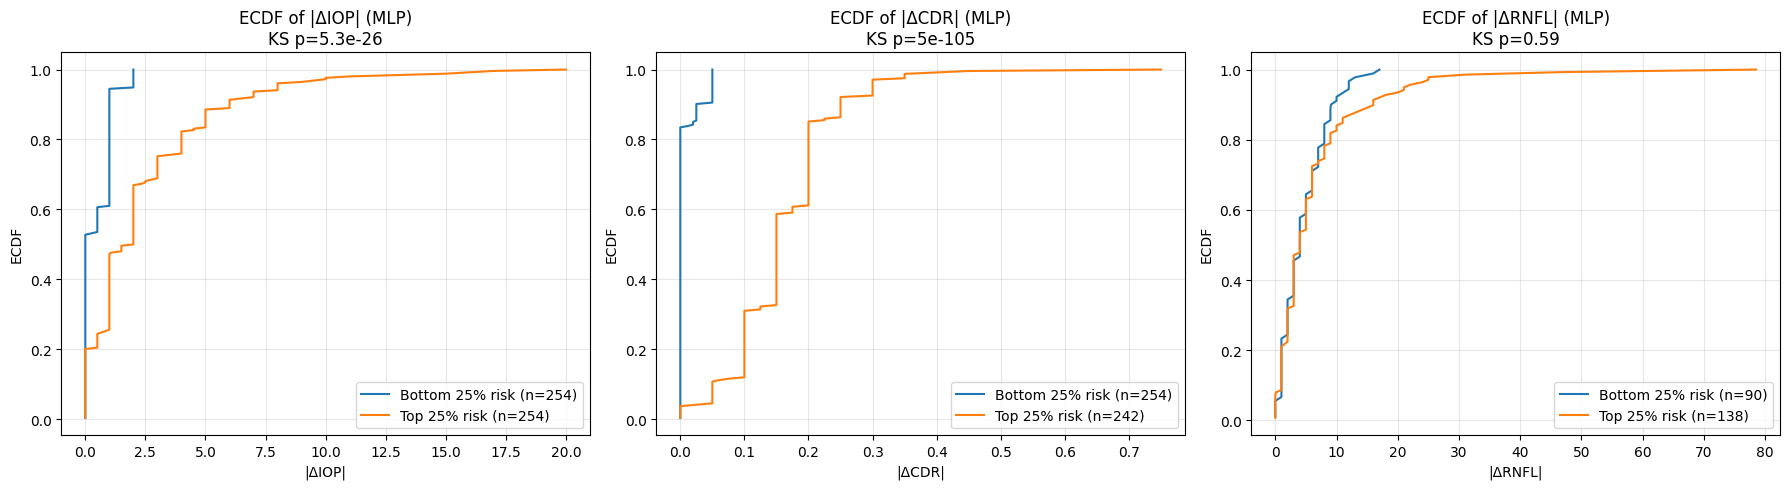

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Phenotype,Pearson_r (bin_mean),Pearson_p,KS_p (top vs bottom 25%),N_low25,N_high25
0,|ΔIOP|,0.874472,9.784728e-07,5.312506e-26,254,254
1,|ΔCDR|,0.918110,3.020884e-08,4.952684e-105,254,242
2,|ΔRNFL|,0.360737,1.698618e-01,5.918141e-01,90,138


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: Asymmetry_Validation_Stats_MLP.xlsx


In [6]:
# --- STEP 6: MLP version (same as RF): train on training cohort, predict risk in suspects, plot Figure 5-style validation ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from google.colab import files

RANDOM_STATE = 42

# =======================
# 0) Load data (fallback if variables not in memory)
# =======================
TRAIN_FILE = "271_training_cohort_4_new_PRS_cleaned.xlsx"
SUSPECT_FILE = "1013_testing_cohort_pure_suspects.xlsx"

try:
    df_train_local = df_train.copy()
    print("✅ Using df_train from memory.")
except NameError:
    train_df_local = pd.read_excel(TRAIN_FILE)
    df_train_local = train_df_local.copy()
    print(f"✅ Loaded training from {TRAIN_FILE}")

try:
    suspect_df_local = suspect_df.copy()
    print("✅ Using suspect_df from memory.")
except NameError:
    suspect_df_local = pd.read_excel(SUSPECT_FILE)
    print(f"✅ Loaded suspects from {SUSPECT_FILE}")

# =======================
# 1) Define feature set (same as RF)
# =======================
FEATURE_COLS = ["delta_IOP", "delta_CDR", "delta_RNFL", "PRS616"]
LABEL_COL = "CaseCtrl"

for c in FEATURE_COLS:
    assert c in df_train_local.columns, f"❌ Missing column in training: {c}"
    assert c in suspect_df_local.columns, f"❌ Missing column in suspects: {c}"
assert LABEL_COL in df_train_local.columns, f"❌ Missing label column in training: {LABEL_COL}"

X_train = df_train_local[FEATURE_COLS].copy()
y_train = df_train_local[LABEL_COL].astype(int).values

print("\n✅ MLP Feature columns:", FEATURE_COLS)
print("Training N:", len(df_train_local), " Label counts:", dict(pd.Series(y_train).value_counts().sort_index()))

# =======================
# 2) Define MLP (match Cell 3 settings)
# =======================
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-3,
    learning_rate_init=1e-3,
    batch_size=32,
    max_iter=2000,
    early_stopping=True,
    n_iter_no_change=50,
    validation_fraction=0.2,
    random_state=RANDOM_STATE
)

pipe_mlp = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", mlp),
])

# Fit on full training cohort
pipe_mlp.fit(X_train, y_train)
print("✅ MLP model fitted on full training cohort.")

# =======================
# 3) Predict risk in suspects
# =======================
X_sus = suspect_df_local[FEATURE_COLS].copy()
pred_risk = pipe_mlp.predict_proba(X_sus)[:, 1]

sus_mlp = suspect_df_local.copy()
sus_mlp["predicted_risk"] = pred_risk
sus_mlp["risk_bin_0.05"] = np.floor(sus_mlp["predicted_risk"] / 0.05) * 0.05
sus_mlp["risk_bin_0.05"] = sus_mlp["risk_bin_0.05"].clip(0, 0.95)

# Asymmetry magnitudes
sus_mlp["abs_delta_IOP"]  = sus_mlp["delta_IOP"].abs()
sus_mlp["abs_delta_CDR"]  = sus_mlp["delta_CDR"].abs()
sus_mlp["abs_delta_RNFL"] = sus_mlp["delta_RNFL"].abs()

print("\nPredicted risk summary (MLP):")
display(sus_mlp["predicted_risk"].describe())

# Save predictions
out_xlsx = "suspect_predicted_risk_MLP_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx"
sus_mlp.to_excel(out_xlsx, index=False)
files.download(out_xlsx)
print("📦 Downloaded:", out_xlsx)

# =======================
# 4) Figure 5A-style: risk bins vs mean(|Δ|) ± SEM + Pearson r/p
# =======================
PHENOS = ["abs_delta_IOP", "abs_delta_CDR", "abs_delta_RNFL"]
PHENO_LABELS = {"abs_delta_IOP":"|ΔIOP|", "abs_delta_CDR":"|ΔCDR|", "abs_delta_RNFL":"|ΔRNFL|"}

MIN_BIN_N = 10  # same as Cell 5 (RF)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    tmp = sus_mlp[["risk_bin_0.05", pheno]].dropna().copy()

    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({
        "mean": g.mean(),
        "sem":  g.std(ddof=1) / np.sqrt(g.count()),
        "n":    g.count()
    }).reset_index()

    stats_f = stats[stats["n"] >= MIN_BIN_N].copy()

    if len(stats_f) >= 3:
        r, p = pearsonr(stats_f["risk_bin_0.05"].values, stats_f["mean"].values)
    else:
        r, p = np.nan, np.nan

    ax.errorbar(stats_f["risk_bin_0.05"], stats_f["mean"], yerr=stats_f["sem"], fmt="o", capsize=3)

    if len(stats_f) >= 2:
        x = stats_f["risk_bin_0.05"].values
        y = stats_f["mean"].values
        coef = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        yy = coef[0]*xx + coef[1]
        ax.plot(xx, yy, linestyle="--")

    ax.set_title(f"{PHENO_LABELS[pheno]} vs Predicted Risk (MLP)\nPearson r={r:.2f}, p={p:.2g} (bins n≥{MIN_BIN_N})")
    ax.set_xlabel("Predicted risk (binned to 0.05)")
    ax.set_ylabel(f"Mean {PHENO_LABELS[pheno]} ± SEM")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
trend_png = "Figure_Asymmetry_Validation_Trend_MLP.png"
plt.savefig(trend_png, dpi=300)
plt.show()
files.download(trend_png)

# =======================
# 5) Figure 5B-style: ECDF Top 25% vs Bottom 25% + KS test
# =======================
q25 = sus_mlp["predicted_risk"].quantile(0.25)
q75 = sus_mlp["predicted_risk"].quantile(0.75)

low = sus_mlp[sus_mlp["predicted_risk"] <= q25].copy()
high = sus_mlp[sus_mlp["predicted_risk"] >= q75].copy()

def ecdf(arr):
    arr = np.sort(arr)
    y = np.arange(1, len(arr)+1) / len(arr)
    return arr, y

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    a = low[pheno].dropna().values
    b = high[pheno].dropna().values

    p_ks = ks_2samp(a, b).pvalue if (len(a) > 0 and len(b) > 0) else np.nan

    xa, ya = ecdf(a)
    xb, yb = ecdf(b)

    ax.plot(xa, ya, label=f"Bottom 25% risk (n={len(a)})")
    ax.plot(xb, yb, label=f"Top 25% risk (n={len(b)})")

    ax.set_title(f"ECDF of {PHENO_LABELS[pheno]} (MLP)\nKS p={p_ks:.2g}")
    ax.set_xlabel(PHENO_LABELS[pheno])
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
ecdf_png = "Figure_Asymmetry_Validation_ECDF_MLP.png"
plt.savefig(ecdf_png, dpi=300)
plt.show()
files.download(ecdf_png)

# =======================
# 6) Save a compact stats summary table
# =======================
summary_rows = []
for pheno in PHENOS:
    tmp = sus_mlp[[pheno, "predicted_risk", "risk_bin_0.05"]].dropna()
    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({
        "mean": g.mean(),
        "sem": g.std(ddof=1)/np.sqrt(g.count()),
        "n": g.count()
    })
    stats = stats[stats["n"] >= MIN_BIN_N].reset_index()

    if len(stats) >= 3:
        r, p = pearsonr(stats["risk_bin_0.05"].values, stats["mean"].values)
    else:
        r, p = np.nan, np.nan

    a = low[pheno].dropna().values
    b = high[pheno].dropna().values
    p_ks = ks_2samp(a, b).pvalue if (len(a) > 0 and len(b) > 0) else np.nan

    summary_rows.append({
        "Phenotype": PHENO_LABELS[pheno],
        "Pearson_r (bin_mean)": r,
        "Pearson_p": p,
        "KS_p (top vs bottom 25%)": p_ks,
        "N_low25": len(a),
        "N_high25": len(b)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

stats_xlsx = "Asymmetry_Validation_Stats_MLP.xlsx"
summary_df.to_excel(stats_xlsx, index=False)
files.download(stats_xlsx)
print("📦 Downloaded:", stats_xlsx)


SVM

✅ Using df_train from memory.
✅ Using suspect_df from memory.

✅ SVM Feature columns: ['delta_IOP', 'delta_CDR', 'delta_RNFL', 'PRS616']
Training N: 271  Label counts: {0: np.int64(143), 1: np.int64(128)}
✅ SVM model fitted on full training cohort.

Predicted risk summary (SVM):


,predicted_risk
count,1013.000000
mean,0.483849
std,0.257863
min,0.038665
25%,0.242165
50%,0.456020
75%,0.730093
max,0.975547


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: suspect_predicted_risk_SVM_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx


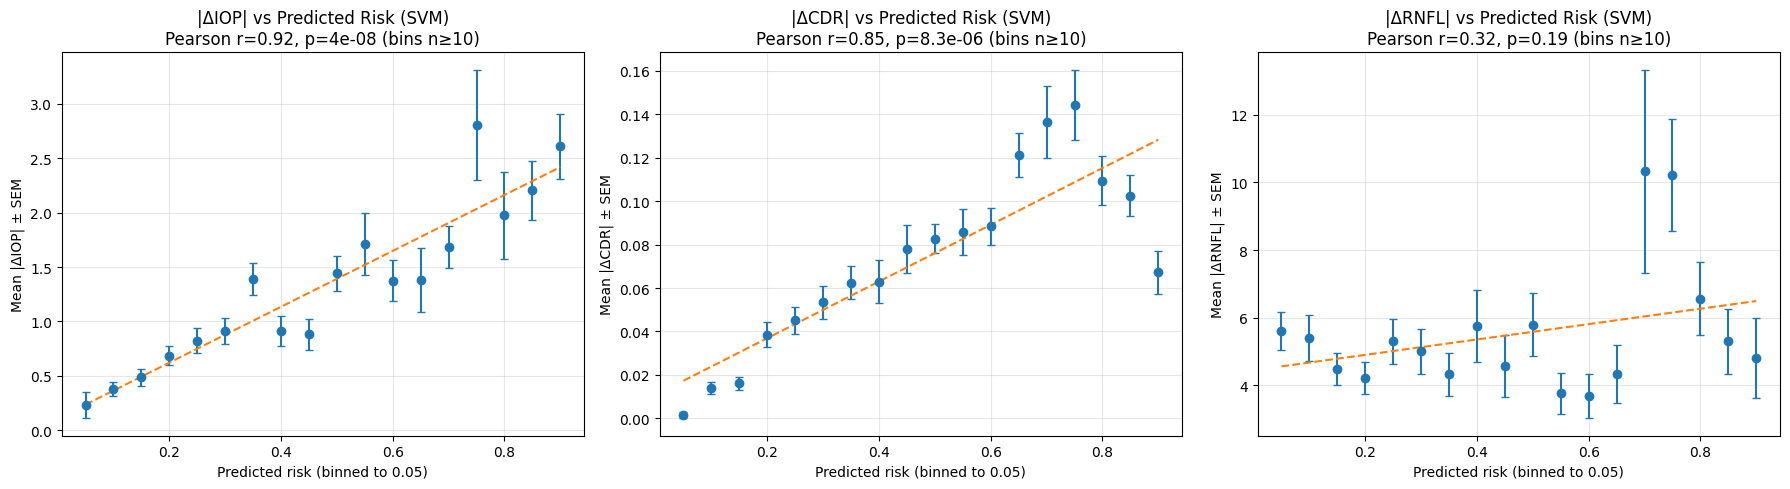

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

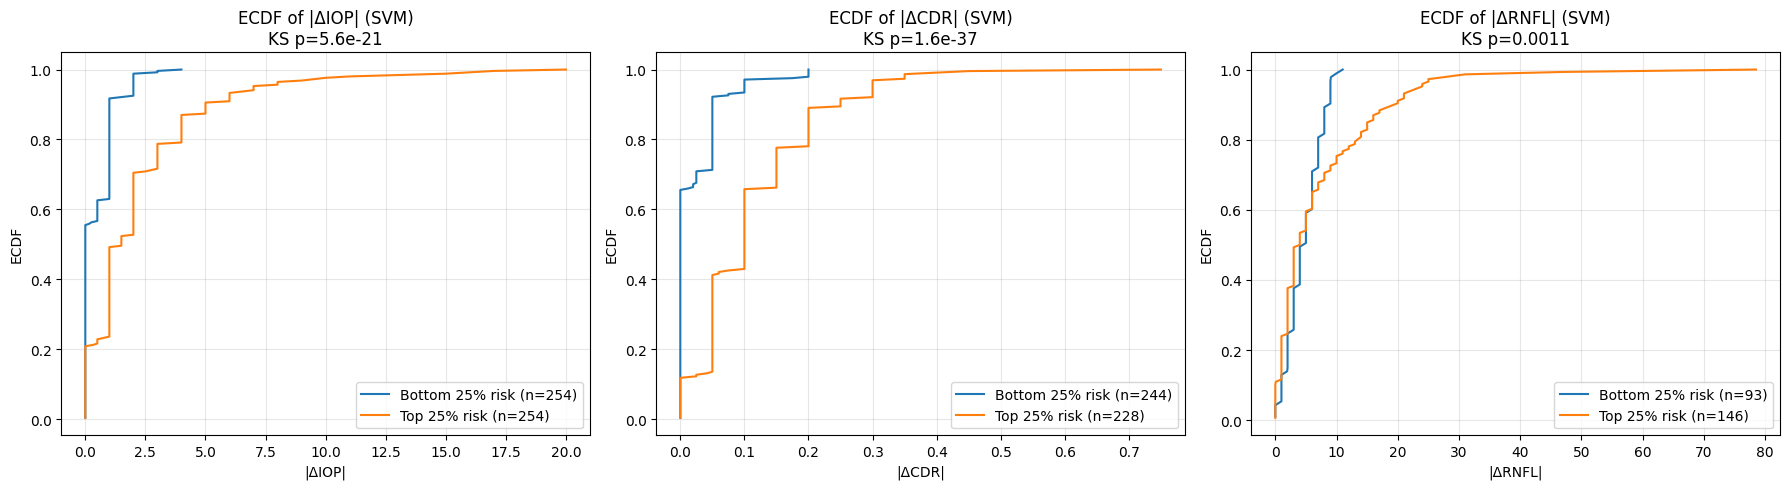

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Phenotype,Pearson_r (bin_mean),Pearson_p,KS_p (top vs bottom 25%),N_low25,N_high25
0,|ΔIOP|,0.924870,4.024799e-08,5.646491e-21,254,254
1,|ΔCDR|,0.849187,8.289616e-06,1.613265e-37,244,228
2,|ΔRNFL|,0.322621,1.916391e-01,1.105378e-03,93,146


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: Asymmetry_Validation_Stats_SVM.xlsx


In [7]:
# --- STEP 7: SVM version (same as RF/MLP): train on training cohort, predict risk in suspects, plot Figure 5-style validation ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ks_2samp

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from google.colab import files

RANDOM_STATE = 42

# =======================
# 0) Load data (fallback if variables not in memory)
# =======================
TRAIN_FILE = "271_training_cohort_4_new_PRS_cleaned.xlsx"
SUSPECT_FILE = "1013_testing_cohort_pure_suspects.xlsx"

try:
    df_train_local = df_train.copy()
    print("✅ Using df_train from memory.")
except NameError:
    train_df_local = pd.read_excel(TRAIN_FILE)
    df_train_local = train_df_local.copy()
    print(f"✅ Loaded training from {TRAIN_FILE}")

try:
    suspect_df_local = suspect_df.copy()
    print("✅ Using suspect_df from memory.")
except NameError:
    suspect_df_local = pd.read_excel(SUSPECT_FILE)
    print(f"✅ Loaded suspects from {SUSPECT_FILE}")

# =======================
# 1) Define feature set (same as RF/MLP)
# =======================
FEATURE_COLS = ["delta_IOP", "delta_CDR", "delta_RNFL", "PRS616"]
LABEL_COL = "CaseCtrl"

for c in FEATURE_COLS:
    assert c in df_train_local.columns, f"❌ Missing column in training: {c}"
    assert c in suspect_df_local.columns, f"❌ Missing column in suspects: {c}"
assert LABEL_COL in df_train_local.columns, f"❌ Missing label column in training: {LABEL_COL}"

X_train = df_train_local[FEATURE_COLS].copy()
y_train = df_train_local[LABEL_COL].astype(int).values

print("\n✅ SVM Feature columns:", FEATURE_COLS)
print("Training N:", len(df_train_local), " Label counts:", dict(pd.Series(y_train).value_counts().sort_index()))

# =======================
# 2) Define SVM (match your Cell 3 settings)
# =======================
svm = SVC(
    kernel="rbf",
    C=4.0,
    gamma=2.0,
    class_weight="balanced",
    probability=True,
    tol=1e-4,
    cache_size=1000,
    random_state=RANDOM_STATE
)

pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", svm),
])

# Fit on full training cohort
pipe_svm.fit(X_train, y_train)
print("✅ SVM model fitted on full training cohort.")

# =======================
# 3) Predict risk in suspects
# =======================
X_sus = suspect_df_local[FEATURE_COLS].copy()
pred_risk = pipe_svm.predict_proba(X_sus)[:, 1]

sus_svm = suspect_df_local.copy()
sus_svm["predicted_risk"] = pred_risk
sus_svm["risk_bin_0.05"] = np.floor(sus_svm["predicted_risk"] / 0.05) * 0.05
sus_svm["risk_bin_0.05"] = sus_svm["risk_bin_0.05"].clip(0, 0.95)

# Asymmetry magnitudes
sus_svm["abs_delta_IOP"]  = sus_svm["delta_IOP"].abs()
sus_svm["abs_delta_CDR"]  = sus_svm["delta_CDR"].abs()
sus_svm["abs_delta_RNFL"] = sus_svm["delta_RNFL"].abs()

print("\nPredicted risk summary (SVM):")
display(sus_svm["predicted_risk"].describe())

# Save predictions
out_xlsx = "suspect_predicted_risk_SVM_deltaIOP_deltaCDR_deltaRNFL_PRS616.xlsx"
sus_svm.to_excel(out_xlsx, index=False)
files.download(out_xlsx)
print("📦 Downloaded:", out_xlsx)

# =======================
# 4) Figure 5A-style: risk bins vs mean(|Δ|) ± SEM + Pearson r/p
# =======================
PHENOS = ["abs_delta_IOP", "abs_delta_CDR", "abs_delta_RNFL"]
PHENO_LABELS = {"abs_delta_IOP":"|ΔIOP|", "abs_delta_CDR":"|ΔCDR|", "abs_delta_RNFL":"|ΔRNFL|"}

MIN_BIN_N = 10  # same as RF/MLP

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    tmp = sus_svm[["risk_bin_0.05", pheno]].dropna().copy()

    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({
        "mean": g.mean(),
        "sem":  g.std(ddof=1) / np.sqrt(g.count()),
        "n":    g.count()
    }).reset_index()

    stats_f = stats[stats["n"] >= MIN_BIN_N].copy()

    if len(stats_f) >= 3:
        r, p = pearsonr(stats_f["risk_bin_0.05"].values, stats_f["mean"].values)
    else:
        r, p = np.nan, np.nan

    ax.errorbar(stats_f["risk_bin_0.05"], stats_f["mean"], yerr=stats_f["sem"], fmt="o", capsize=3)

    if len(stats_f) >= 2:
        x = stats_f["risk_bin_0.05"].values
        y = stats_f["mean"].values
        coef = np.polyfit(x, y, 1)
        xx = np.linspace(x.min(), x.max(), 100)
        yy = coef[0]*xx + coef[1]
        ax.plot(xx, yy, linestyle="--")

    ax.set_title(f"{PHENO_LABELS[pheno]} vs Predicted Risk (SVM)\nPearson r={r:.2f}, p={p:.2g} (bins n≥{MIN_BIN_N})")
    ax.set_xlabel("Predicted risk (binned to 0.05)")
    ax.set_ylabel(f"Mean {PHENO_LABELS[pheno]} ± SEM")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
trend_png = "Figure_Asymmetry_Validation_Trend_SVM.png"
plt.savefig(trend_png, dpi=300)
plt.show()
files.download(trend_png)

# =======================
# 5) Figure 5B-style: ECDF Top 25% vs Bottom 25% + KS test
# =======================
q25 = sus_svm["predicted_risk"].quantile(0.25)
q75 = sus_svm["predicted_risk"].quantile(0.75)

low = sus_svm[sus_svm["predicted_risk"] <= q25].copy()
high = sus_svm[sus_svm["predicted_risk"] >= q75].copy()

def ecdf(arr):
    arr = np.sort(arr)
    y = np.arange(1, len(arr)+1) / len(arr)
    return arr, y

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, pheno in zip(axes, PHENOS):
    a = low[pheno].dropna().values
    b = high[pheno].dropna().values

    p_ks = ks_2samp(a, b).pvalue if (len(a) > 0 and len(b) > 0) else np.nan

    xa, ya = ecdf(a)
    xb, yb = ecdf(b)

    ax.plot(xa, ya, label=f"Bottom 25% risk (n={len(a)})")
    ax.plot(xb, yb, label=f"Top 25% risk (n={len(b)})")

    ax.set_title(f"ECDF of {PHENO_LABELS[pheno]} (SVM)\nKS p={p_ks:.2g}")
    ax.set_xlabel(PHENO_LABELS[pheno])
    ax.set_ylabel("ECDF")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
ecdf_png = "Figure_Asymmetry_Validation_ECDF_SVM.png"
plt.savefig(ecdf_png, dpi=300)
plt.show()
files.download(ecdf_png)

# =======================
# 6) Save a compact stats summary table
# =======================
summary_rows = []
for pheno in PHENOS:
    tmp = sus_svm[[pheno, "predicted_risk", "risk_bin_0.05"]].dropna()
    g = tmp.groupby("risk_bin_0.05")[pheno]
    stats = pd.DataFrame({
        "mean": g.mean(),
        "sem": g.std(ddof=1)/np.sqrt(g.count()),
        "n": g.count()
    })
    stats = stats[stats["n"] >= MIN_BIN_N].reset_index()

    if len(stats) >= 3:
        r, p = pearsonr(stats["risk_bin_0.05"].values, stats["mean"].values)
    else:
        r, p = np.nan, np.nan

    a = low[pheno].dropna().values
    b = high[pheno].dropna().values
    p_ks = ks_2samp(a, b).pvalue if (len(a) > 0 and len(b) > 0) else np.nan

    summary_rows.append({
        "Phenotype": PHENO_LABELS[pheno],
        "Pearson_r (bin_mean)": r,
        "Pearson_p": p,
        "KS_p (top vs bottom 25%)": p_ks,
        "N_low25": len(a),
        "N_high25": len(b)
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

stats_xlsx = "Asymmetry_Validation_Stats_SVM.xlsx"
summary_df.to_excel(stats_xlsx, index=False)
files.download(stats_xlsx)
print("📦 Downloaded:", stats_xlsx)


AUC Visualization

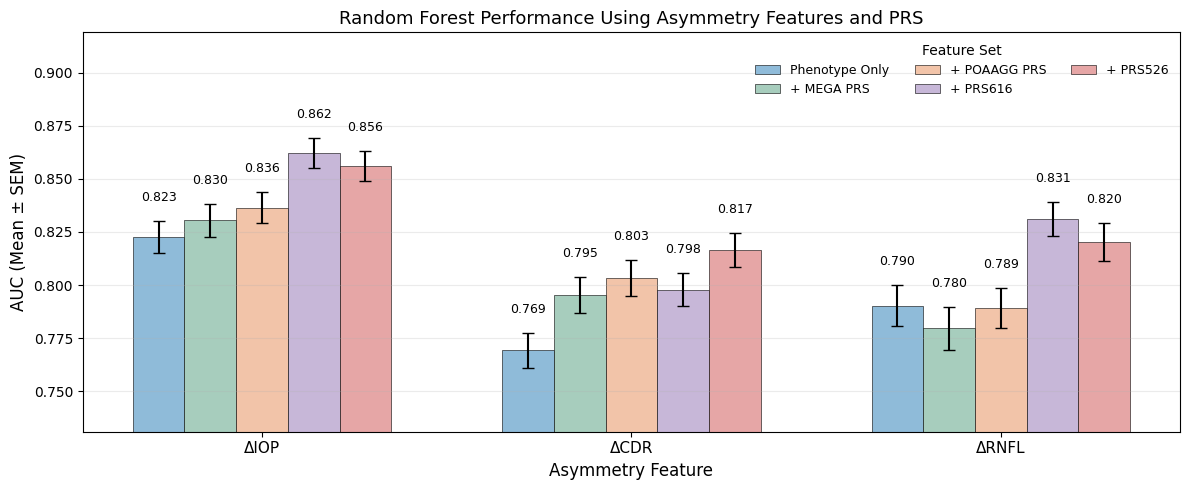

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: Figure_Asymmetry_AUC_RF_Polished.png


In [11]:
# --- STEP 8 (Final polished): Random Forest AUC for Asymmetry + PRS (publication-ready style) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

AUC_LONG_FILE = "asymmetry_bootstrap_metrics_long.xlsx"

# =====================
# 1) Load and filter AUC (RF only)
# =====================
df = pd.read_excel(AUC_LONG_FILE)
df = df[(df["Metric"] == "AUC") & (df["Model"] == "RF")].copy()

deltas = ["delta_IOP", "delta_CDR", "delta_RNFL"]
prs_map = {
    "delta_only": "Phenotype Only",
    "MEGA PRS": "+ MEGA PRS",
    "POAAGG PRS": "+ POAAGG PRS",
    "PRS616": "+ PRS616",
    "PRS526": "+ PRS526",
}

wanted = set(deltas)
for d in deltas:
    for prs in ["MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]:
        wanted.add(f"{d}+{prs}")

df = df[df["FeatureSet"].isin(wanted)].copy()

def parse_fs(fs):
    if fs in deltas:
        return fs, "delta_only"
    d, prs = fs.split("+", 1)
    return d, prs

df[["delta", "prs_variant"]] = df["FeatureSet"].apply(lambda x: pd.Series(parse_fs(x)))

# =====================
# 2) Prepare plotting matrices
# =====================
prs_order = ["delta_only", "MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]
delta_order = deltas

plot_df = df.pivot_table(
    index="delta",
    columns="prs_variant",
    values=["Mean", "SEM"],
    aggfunc="first"
)

means = plot_df["Mean"].reindex(index=delta_order, columns=prs_order).values
sems  = plot_df["SEM"].reindex(index=delta_order, columns=prs_order).values

# =====================
# 3) Soft color palette (low saturation, print-friendly)
# =====================
colors = [
    "#8FBBD9",  # Feature only - soft blue
    "#A7CDBD",  # MEGA PRS - soft teal
    "#F2C4A9",  # POAAGG PRS - soft peach
    "#C7B7D8",  # PRS616 - soft lavender
    "#E6A6A6",  # PRS526 - soft rose
]

# =====================
# 4) Plot grouped bars
# =====================
x = np.arange(len(delta_order))
bar_w = 0.14
offsets = (np.arange(len(prs_order)) - (len(prs_order) - 1) / 2) * bar_w

plt.figure(figsize=(12, 5))

for i, prs in enumerate(prs_order):
    xi = x + offsets[i]
    yi = means[:, i]
    ei = sems[:, i]

    bars = plt.bar(
        xi, yi, width=bar_w,
        yerr=ei, capsize=4,
        color=colors[i],
        label=prs_map[prs],
        edgecolor="black",
        linewidth=0.4
    )

    # --- improved numeric AUC labels (avoid overlap with bars / error bars) ---
    for bx, by, err in zip(xi, yi, ei):
        pad = err if not np.isnan(err) else 0
        plt.text(
            bx,
            by + pad + 0.008,   # <-- adaptive offset
            f"{by:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )


# =====================
# 5) Axes, labels, legend
# =====================
plt.xticks(x, ["ΔIOP", "ΔCDR", "ΔRNFL"], fontsize=11)
plt.xlabel("Asymmetry Feature", fontsize=12)
plt.ylabel("AUC (Mean ± SEM)", fontsize=12)
plt.title("Random Forest Performance Using Asymmetry Features and PRS", fontsize=13)

plt.legend(
    title="Feature Set",
    ncol=3,
    fontsize=9,
    title_fontsize=10,
    frameon=False
)

plt.grid(axis="y", alpha=0.25)

y_min = np.nanmin(means - sems) - 0.03
y_max = np.nanmax(means + sems) + 0.05
plt.ylim(max(0.5, y_min), min(1.0, y_max))

plt.tight_layout()

out_png = "Figure_Asymmetry_AUC_RF_Polished.png"
plt.savefig(out_png, dpi=300)
plt.show()

files.download(out_png)
print("📦 Downloaded:", out_png)


MLP

,delta,FeatureSetLabel,Mean,SEM,Mean±SEM
0,delta_CDR,+ MEGA PRS,0.754483,0.009896,0.754 ± 0.010
1,delta_CDR,+ POAAGG PRS,0.763435,0.008751,0.763 ± 0.009
2,delta_CDR,+ PRS526,0.759178,0.007703,0.759 ± 0.008
3,delta_CDR,+ PRS616,0.757825,0.008057,0.758 ± 0.008
4,delta_CDR,Phenotype Only,0.764655,0.007846,0.765 ± 0.008
5,delta_IOP,+ MEGA PRS,0.797347,0.009560,0.797 ± 0.010
6,delta_IOP,+ POAAGG PRS,0.800862,0.009609,0.801 ± 0.010
7,delta_IOP,+ PRS526,0.814775,0.009790,0.815 ± 0.010
8,delta_IOP,+ PRS616,0.820690,0.008587,0.821 ± 0.009
9,delta_IOP,Phenotype Only,0.810106,0.007821,0.810 ± 0.008


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

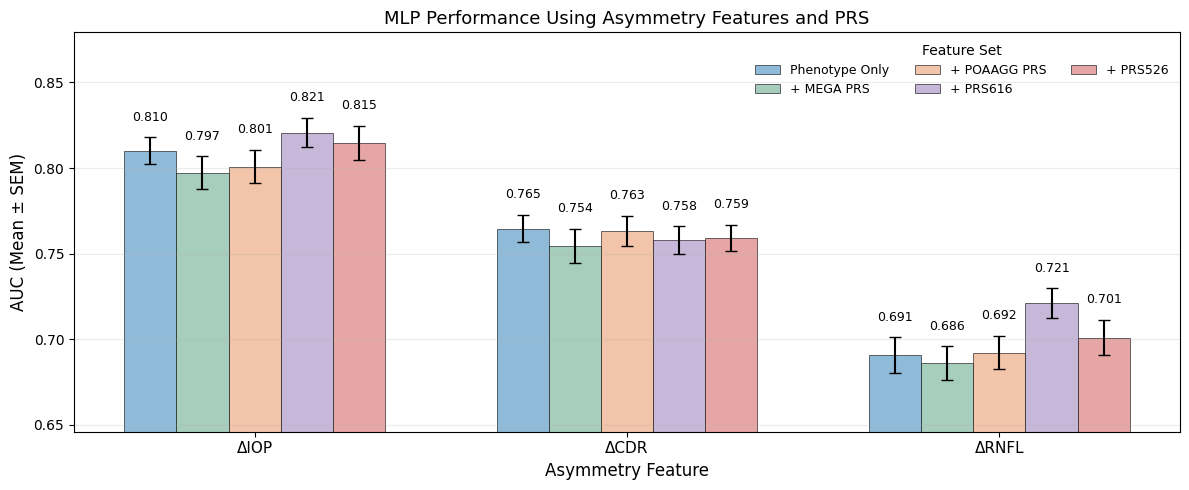

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: Figure_Asymmetry_AUC_MLP_Polished.png


In [12]:
# --- STEP 9: Visualize AUC (MLP only) for delta-only and delta+4 PRS (no ALL_PRS) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

AUC_LONG_FILE = "asymmetry_bootstrap_metrics_long.xlsx"

# =====================
# 1) Load and filter AUC (MLP only)
# =====================
df = pd.read_excel(AUC_LONG_FILE)
df = df[(df["Metric"] == "AUC") & (df["Model"] == "MLP")].copy()

deltas = ["delta_IOP", "delta_CDR", "delta_RNFL"]
prs_map = {
    "delta_only": "Phenotype Only",
    "MEGA PRS": "+ MEGA PRS",
    "POAAGG PRS": "+ POAAGG PRS",
    "PRS616": "+ PRS616",
    "PRS526": "+ PRS526",
}

wanted = set(deltas)
for d in deltas:
    for prs in ["MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]:
        wanted.add(f"{d}+{prs}")

df = df[df["FeatureSet"].isin(wanted)].copy()

def parse_fs(fs):
    if fs in deltas:
        return fs, "delta_only"
    d, prs = fs.split("+", 1)
    return d, prs

df[["delta", "prs_variant"]] = df["FeatureSet"].apply(lambda x: pd.Series(parse_fs(x)))

# =====================
# 2) Prepare plotting matrices
# =====================
prs_order = ["delta_only", "MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]
delta_order = deltas

plot_df = df.pivot_table(
    index="delta",
    columns="prs_variant",
    values=["Mean", "SEM"],
    aggfunc="first"
)

means = plot_df["Mean"].reindex(index=delta_order, columns=prs_order).values
sems  = plot_df["SEM"].reindex(index=delta_order, columns=prs_order).values

# Save summary table (optional but handy for supplement)
summary = (df.copy()
             .assign(FeatureSetLabel=lambda t: t["prs_variant"].map(prs_map))
             .sort_values(["delta", "FeatureSetLabel"])
             [["delta", "FeatureSetLabel", "Mean", "SEM", "Mean±SEM"]]
             .reset_index(drop=True))
display(summary)
summary_xlsx = "AUC_MLP_summary_table.xlsx"
summary.to_excel(summary_xlsx, index=False)
files.download(summary_xlsx)

# =====================
# 3) Soft palette (same as RF)
# =====================
colors = [
    "#8FBBD9",  # Feature only
    "#A7CDBD",  # MEGA PRS
    "#F2C4A9",  # POAAGG PRS
    "#C7B7D8",  # PRS616
    "#E6A6A6",  # PRS526
]

# =====================
# 4) Plot grouped bars
# =====================
x = np.arange(len(delta_order))
bar_w = 0.14
offsets = (np.arange(len(prs_order)) - (len(prs_order) - 1) / 2) * bar_w

plt.figure(figsize=(12, 5))

for i, prs in enumerate(prs_order):
    xi = x + offsets[i]
    yi = means[:, i]
    ei = sems[:, i]

    plt.bar(
        xi, yi, width=bar_w,
        yerr=ei, capsize=4,
        color=colors[i],
        label=prs_map[prs],
        edgecolor="black",
        linewidth=0.4
    )

    # labels (avoid overlap with error bars)
    for bx, by, err in zip(xi, yi, ei):
        pad = err if not np.isnan(err) else 0
        plt.text(bx, by + pad + 0.008, f"{by:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["ΔIOP", "ΔCDR", "ΔRNFL"], fontsize=11)
plt.xlabel("Asymmetry Feature", fontsize=12)
plt.ylabel("AUC (Mean ± SEM)", fontsize=12)
plt.title("MLP Performance Using Asymmetry Features and PRS", fontsize=13)

plt.legend(title="Feature Set", ncol=3, fontsize=9, title_fontsize=10, frameon=False)
plt.grid(axis="y", alpha=0.25)

y_min = np.nanmin(means - sems) - 0.03
y_max = np.nanmax(means + sems) + 0.05
plt.ylim(max(0.5, y_min), min(1.0, y_max))

plt.tight_layout()

out_png = "Figure_Asymmetry_AUC_MLP_Polished.png"
plt.savefig(out_png, dpi=300)
plt.show()

files.download(out_png)
print("📦 Downloaded:", out_png)


SVM

,delta,FeatureSetLabel,Mean,SEM,Mean±SEM
0,delta_CDR,+ MEGA PRS,0.766963,0.009893,0.767 ± 0.010
1,delta_CDR,+ POAAGG PRS,0.780782,0.009483,0.781 ± 0.009
2,delta_CDR,+ PRS526,0.771021,0.009904,0.771 ± 0.010
3,delta_CDR,+ PRS616,0.770119,0.007762,0.770 ± 0.008
4,delta_CDR,Phenotype Only,0.745000,0.009378,0.745 ± 0.009
5,delta_IOP,+ MEGA PRS,0.791671,0.010178,0.792 ± 0.010
6,delta_IOP,+ POAAGG PRS,0.797122,0.009206,0.797 ± 0.009
7,delta_IOP,+ PRS526,0.842997,0.007699,0.843 ± 0.008
8,delta_IOP,+ PRS616,0.833236,0.006377,0.833 ± 0.006
9,delta_IOP,Phenotype Only,0.804695,0.008276,0.805 ± 0.008


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

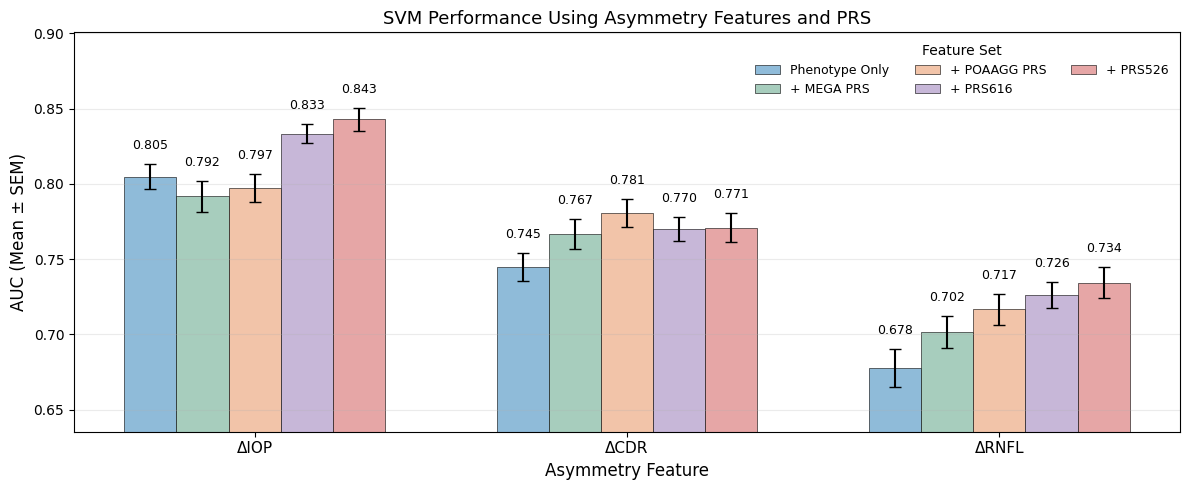

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Downloaded: Figure_Asymmetry_AUC_SVM_Polished.png


In [13]:
# --- STEP 10: Visualize AUC (SVM only) for delta-only and delta+4 PRS (no ALL_PRS) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

AUC_LONG_FILE = "asymmetry_bootstrap_metrics_long.xlsx"

# =====================
# 1) Load and filter AUC (SVM only)
# =====================
df = pd.read_excel(AUC_LONG_FILE)
df = df[(df["Metric"] == "AUC") & (df["Model"] == "SVM")].copy()

deltas = ["delta_IOP", "delta_CDR", "delta_RNFL"]
prs_map = {
    "delta_only": "Phenotype Only",
    "MEGA PRS": "+ MEGA PRS",
    "POAAGG PRS": "+ POAAGG PRS",
    "PRS616": "+ PRS616",
    "PRS526": "+ PRS526",
}

wanted = set(deltas)
for d in deltas:
    for prs in ["MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]:
        wanted.add(f"{d}+{prs}")

df = df[df["FeatureSet"].isin(wanted)].copy()

def parse_fs(fs):
    if fs in deltas:
        return fs, "delta_only"
    d, prs = fs.split("+", 1)
    return d, prs

df[["delta", "prs_variant"]] = df["FeatureSet"].apply(lambda x: pd.Series(parse_fs(x)))

# =====================
# 2) Prepare plotting matrices
# =====================
prs_order = ["delta_only", "MEGA PRS", "POAAGG PRS", "PRS616", "PRS526"]
delta_order = deltas

plot_df = df.pivot_table(
    index="delta",
    columns="prs_variant",
    values=["Mean", "SEM"],
    aggfunc="first"
)

means = plot_df["Mean"].reindex(index=delta_order, columns=prs_order).values
sems  = plot_df["SEM"].reindex(index=delta_order, columns=prs_order).values

# Save summary table (optional)
summary = (df.copy()
             .assign(FeatureSetLabel=lambda t: t["prs_variant"].map(prs_map))
             .sort_values(["delta", "FeatureSetLabel"])
             [["delta", "FeatureSetLabel", "Mean", "SEM", "Mean±SEM"]]
             .reset_index(drop=True))
display(summary)
summary_xlsx = "AUC_SVM_summary_table.xlsx"
summary.to_excel(summary_xlsx, index=False)
files.download(summary_xlsx)

# =====================
# 3) Soft palette (same as RF/MLP)
# =====================
colors = [
    "#8FBBD9",
    "#A7CDBD",
    "#F2C4A9",
    "#C7B7D8",
    "#E6A6A6",
]

# =====================
# 4) Plot grouped bars
# =====================
x = np.arange(len(delta_order))
bar_w = 0.14
offsets = (np.arange(len(prs_order)) - (len(prs_order) - 1) / 2) * bar_w

plt.figure(figsize=(12, 5))

for i, prs in enumerate(prs_order):
    xi = x + offsets[i]
    yi = means[:, i]
    ei = sems[:, i]

    plt.bar(
        xi, yi, width=bar_w,
        yerr=ei, capsize=4,
        color=colors[i],
        label=prs_map[prs],
        edgecolor="black",
        linewidth=0.4
    )

    # labels (avoid overlap with error bars)
    for bx, by, err in zip(xi, yi, ei):
        pad = err if not np.isnan(err) else 0
        plt.text(bx, by + pad + 0.008, f"{by:.3f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, ["ΔIOP", "ΔCDR", "ΔRNFL"], fontsize=11)
plt.xlabel("Asymmetry Feature", fontsize=12)
plt.ylabel("AUC (Mean ± SEM)", fontsize=12)
plt.title("SVM Performance Using Asymmetry Features and PRS", fontsize=13)

plt.legend(title="Feature Set", ncol=3, fontsize=9, title_fontsize=10, frameon=False)
plt.grid(axis="y", alpha=0.25)

y_min = np.nanmin(means - sems) - 0.03
y_max = np.nanmax(means + sems) + 0.05
plt.ylim(max(0.5, y_min), min(1.0, y_max))

plt.tight_layout()

out_png = "Figure_Asymmetry_AUC_SVM_Polished.png"
plt.savefig(out_png, dpi=300)
plt.show()

files.download(out_png)
print("📦 Downloaded:", out_png)
